# Getting Started

In this notebook we will get you started with the *easiest* way to use `matvis` directly.
We will learn how to set up the various parameters required, and plot the outputs. 

Note that there are two main ways to use `matvis`: the low-level API is considered to be the 
"algorithm" and defines the interface that all implementations must expose. There are 
*two* such implementations in this package (`matvis_cpu` and `matvis_gpu`). Here, we will use
the *high-level* "wrapper" API, which is provided as a convenience and "example" of how
to use `matvis`. In practice, using this high-level API should typically be sufficient.

<div class="alert alert-info">
    
Note
   
The absolute easiest way to use `matvis` is via the `hera_sim` [plugin interface](https://hera-sim.readthedocs.io/en/latest/tutorials/hera_sim_vis_cli.html).
</div>

<div class="alert alert-warning">

Warning

Before running this tutorial, you should make sure you understand the basic concepts
and algorithm that `matvis` uses. You can read up on that [here](../understanding_the_algorithm.html)
</div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from pyuvdata.telescopes import Telescope
from astropy.time import Time

from matvis import simulate_vis
from pyuvdata.analytic_beam import GaussianBeam, UniformBeam

## Setup Telescope / Observation Parameters

We need a few input parameters to setup our observation: antenna positions, beam models,
and a sky model. 

Here we will set up a very simple observation for introductory purposes. 

First, create our antenna positions. We define this as a dictionary, which maps an 
antenna number to its 3D East-North-Up position relative to the array centre. We define
just three antennas, in a right-angle triangle with side length 14m.

In [2]:
ants = {
    0: (0, 0, 0),
    1: (14, 0, 0),
    2: (0, 14, 0)
}

Now, let's define the beams for each of these antennas. `matvis` allows us to specify
different beams for each antenna, but we need only specify *unique* beams. Each beam
must be either a `UVBeam` or `AnalyticBeam`. Here, for simplicity we just use some
subclasses of the `AnalyticBeam` class. You can create your own custom `AnalyticBeam`
classes to use as well (see the [pyuvdata tutorial](https://pyuvdata.readthedocs.io/en/latest/analytic_beam_tutorial.html#defining-new-analytic-beams)).

In [ ]:
beams = [GaussianBeam(sigma=0.5), UniformBeam("uniform")]
beam_idx = [0, 0, 1]

Here, we specified two unique beams for three antennas. The `beam_idx` tells each antenna
which beam to use. Thus antenna 0 and 1 will use the Gaussian beam, while antenna 2 will
use the uniform beam.

We also need to tell `matvis` the observational configuration, such as the frequency
channels and times to use:

First, let's define our frequency channels:

In [4]:
# Frequencies in Hz
Nfreqs = 10
freqs = np.linspace(1e8 , 1.2e8, Nfreqs)

In [11]:
# LSTs in radians
Ntimes = 20
times = Time(np.linspace(2459845, 2459845.5, Ntimes), format='jd', scale='utc')

## Setup Sky Model

`matvis` makes the "point source approximation" -- that is, it breaks the sky into a 
series of sources that it sums over. This is an approximation for a diffuse sky model,
but is exact for a point-source sky. In this introduction, let us assume a simple point
source sky with just a few sources.

In [31]:
nsource = 35

ra = np.deg2rad(np.linspace(0. , 360, nsource))        # ra of each source (in rad)
dec = np.deg2rad(np.linspace(-60. , 10.0, nsource))    # dec of each source (in rad)
flux = np.ones(nsource)                                # flux of each source at 100MHz (in Jy)
sp_index = np.ones(nsource) * -0.8                     # sp. index of each source

# Now get the (Nsource, Nfreq) array of the flux of each source at each frequency.
flux_allfreq = ((freqs[:, np.newaxis] / freqs[0]) ** sp_index.T * flux.T).T

## Run matvis

Now that we've setup all our parameters, we can easily run the simulation using the 
high-level wrapper API. Along with the configuration we've already defined, the 
`simulate_vis` wrapper takes a few extra options. One of the most important is 
`polarized`: if true, then full polarized visibilities are returned (with shape
`(nfreqs, ntimes, nfeed, nfeed, nants, nants)`), otherwise, unpolarized visibilities
are returned (with shape `(nfreqs, ntimes, nants, nants)`). In our case, the 
`AnalyticBeam` objects we're using don't support polarization, so we set this to false.

We can also set the `precision` parameter, which switches between 32-bit (if `precision=1`)
and 64-bit (if `precision=2`) floating precision. 

In [32]:
# simulate visibilities 
vis_vc = simulate_vis(
    ants=ants,
    fluxes=flux_allfreq,
    ra=ra,
    dec=dec,
    freqs=freqs,
    times=times,
    telescope_loc=Telescope.from_known_telescopes('hera').location,
    beams=beams,
    beam_idx=np.array(beam_idx),
    polarized=False,
    precision=2,
)

In [33]:
vis_vc.shape = (Nfreqs, Ntimes, len(ants), len(ants))

# Plot auto and cross visibilities

Here, we plot the visibility amplitude and phase as a function of frequency and LSTs. For auto-correlation (e.g. antenna pair (0,0)) we expect the phase would be zero. Here, the amplitude is constant with frequency as we assumed the spectral of the sources are zero.

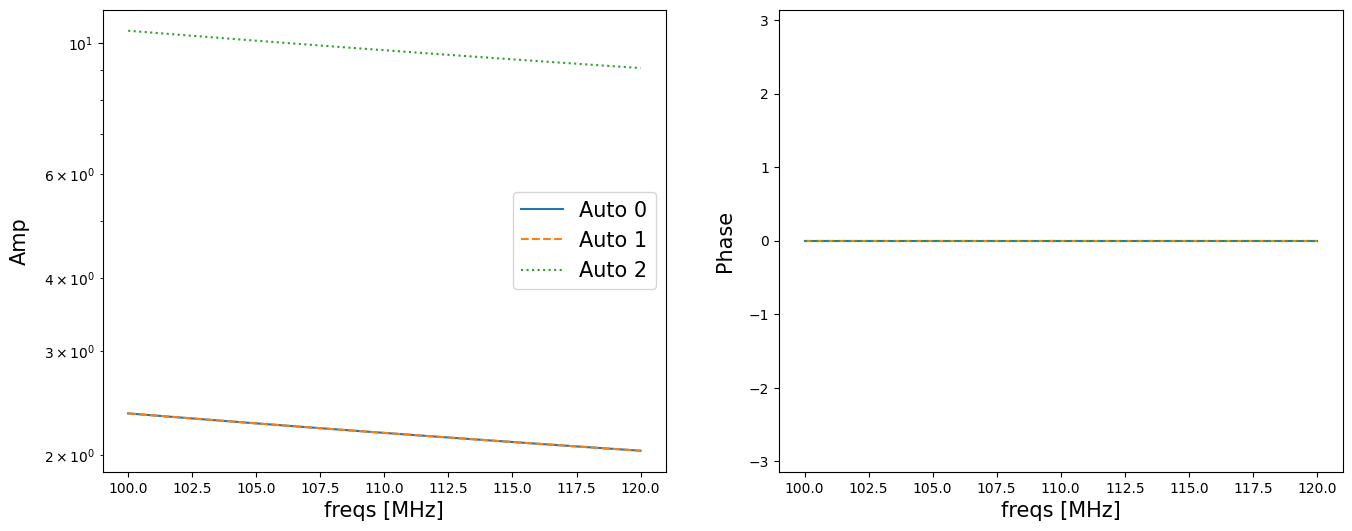

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for ant in range(3):
    ax[0].plot(freqs/1.e6, np.abs(vis_vc[:,0,ant, ant]), ls=['-', '--', ':'][ant], label=rf'Auto {ant}')
    ax[0].set_ylabel('Amp', fontsize=15,labelpad=10)
    ax[0].set_xlabel(r'freqs [MHz]', fontsize=15)
    ax[0].set_yscale('log')
    ax[0].legend(fontsize=15)


    ax[1].plot(freqs/1.e6, np.angle(vis_vc[:,0,ant, ant]), ls=['-', '--', ':'][ant])
    ax[1].set_ylabel('Phase', fontsize=15,labelpad=10)
    ax[1].set_xlabel(r'freqs [MHz]', fontsize=15)
    ax[1].set_ylim(-np.pi, np.pi)

plt.show()

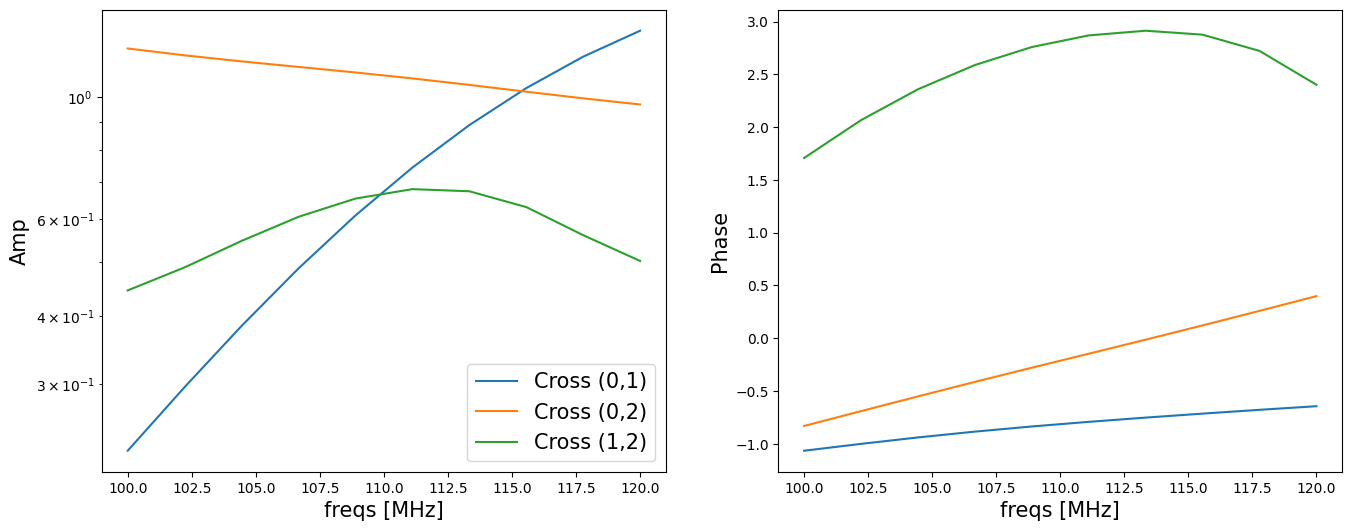

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for ant1 in range(3):
    for ant2 in range(ant1+1, 3):
        ax[0].plot(freqs/1.e6, np.abs(vis_vc[:,0,ant1,ant2]), label=rf'Cross ({ant1},{ant2})')
        ax[0].set_ylabel('Amp', fontsize=15)
        ax[0].set_xlabel(r'freqs [MHz]', fontsize=15)
        ax[0].set_yscale('log')
        ax[0].legend(fontsize=15)


        ax[1].plot(freqs/1.e6, np.unwrap(np.angle(vis_vc[:,0,ant1,ant2])))
        ax[1].set_ylabel('Phase', fontsize=15)
        ax[1].set_xlabel(r'freqs [MHz]', fontsize=15)

plt.show()

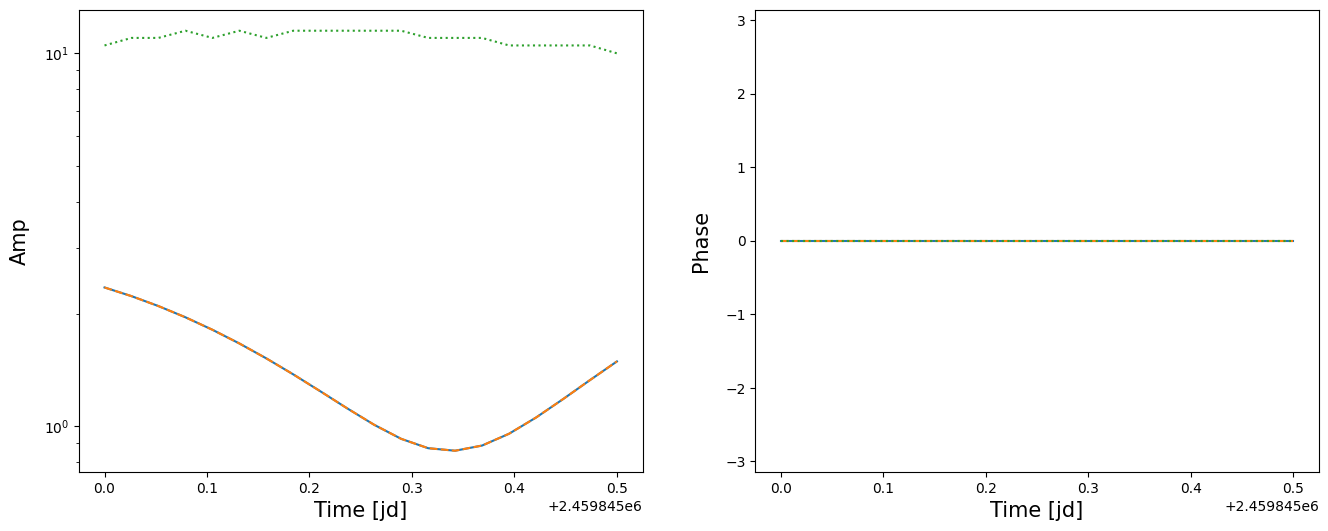

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for ant in range(3):
    ax[0].plot(times.jd, np.abs(vis_vc[0,:,ant, ant]), ls=['-', '--', ':'][ant], label=rf'Auto {ant}')
    ax[0].set_ylabel('Amp', fontsize=15,labelpad=10)
    ax[0].set_xlabel(r'Time [jd]', fontsize=15)
    ax[0].set_yscale('log')

    ax[1].plot(times.jd, np.angle(vis_vc[0,:,ant, ant]), ls=['-', '--', ':'][ant])
    ax[1].set_ylabel('Phase', fontsize=15,labelpad=10)
    ax[1].set_xlabel(r'Time [jd]', fontsize=15)
    ax[1].set_ylim(-np.pi, np.pi)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


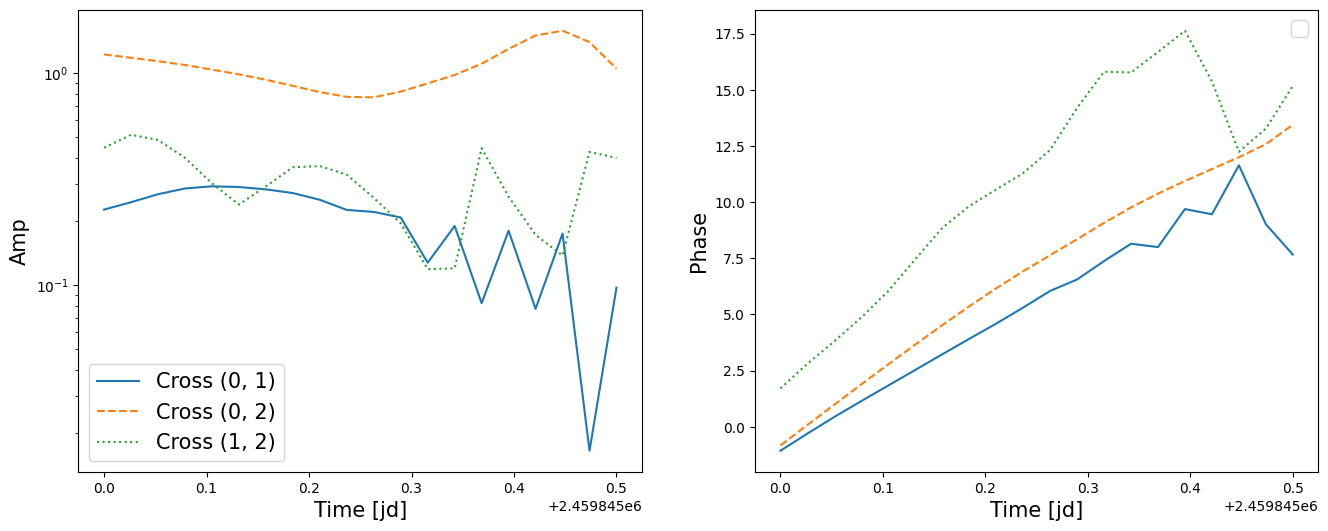

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for ant1 in range(3):
    for ant2 in range(ant1+1, 3):
        ls = ['-', '--', ':'][ant1+ant2 - 1]
        ax[0].plot(times.jd, np.abs(vis_vc[0,:,ant1,ant2]), label=f'Cross ({ant1}, {ant2})',ls=ls)
        ax[0].set_ylabel('Amp', fontsize=15)
        ax[0].set_xlabel(r'Time [jd]', fontsize=15)
        ax[0].set_yscale('log')
        ax[0].legend(fontsize=15)



        ax[1].plot(times.jd, np.unwrap(np.angle(vis_vc[0,:,ant1, ant2])),ls=ls)
        ax[1].set_ylabel('Phase', fontsize=15)
        ax[1].set_xlabel(r'Time [jd]', fontsize=15)
        ax[1].legend(fontsize=15)

plt.show()